### introduction

Here we will go through application of the TEA algorithm to eddy covariance data. The script is designed to run on [FLUXNET2015](https://fluxnet.fluxdata.org/data/fluxnet2015-dataset/) .csv files directly, which ensures consistent variable names, processing and units. The tutorial will use data from the [Hyytiala forest](http://sites.fluxdata.org/FI-Hyy/) in Finland, but can be applied to any FLUXNET2015 dataset.

Some experience in Python will make things easy, but I will try to explain the process step by step so as to be accessible to all backgrounds.

### resource usage

Note that processing large dataset can take some time and memory use. This script only processes six years worth of data. Processing the original 18 year dataset with one processor takes approximately 10 minutes and 0.75 GiB of RAM. If you have access to a multi-core processor, the speed can be increased considerably. Here are the maximum memory usage and run times when using different number of processors on my laptop:

| processors |   max memory   | time     |
|:----------:|:--------------:|:--------:|
| 1          |     0.5 GiB    | 2min 18s |
| 2          |     0.6 GiB    | 1min 32s |
| 4          |     0.6 GiB    | 0min 50s |
| 8          |     0.6 GiB    | 0min 41s |

Setting the number of processors is explained later in the tutorial.

### first things first

The firs step is to import all needed packages:

In [1]:
import xarray as xr # labelled multi-dimensional arrays that are compatable with netcdf formats
import numpy as np # numerical python for working with basic n-dimensional array
import warnings # standard library for suppressing warnings

import TEA # This is the actual TEA code

# This secion facilitates easy plotting using xarray/pandas
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

# These two packages are imported from local scripts in the repository
from preprocess import build_dataset # Converts the .csv to a labeled xarray Dataset
import bigleaf # Used for converting units (e.g. LE to ET)

### loading the dataset

Here we used the build_datset function from the preprocess.py script, which chooses a subset of the variables from the FULLSET, as well as setting units, descriptive names, and site metadata into the file. Furthermore, only the years from 2008 to 2013 are seleced from the full timeseries. Comment out the second line if you would like to run the full datset.

In [2]:
ec = build_dataset("FLX_FI-Hyy_FLUXNET2015_FULLSET_HH_2008-2010_1-3.csv")

### check for an hourly file

**build_dataset** also check to see if the file is at hourly or half hourly resolution. We will be working with ET in units of mm per timestep, and therefor some calculations are slightly different.

In [3]:
if ec.agg_code == 'HH':
    hourlyMask      = xr.DataArray(np.ones(ec.time.shape).astype(bool),coords=[ec.time],dims=['time'])
    nStepsPerDay    = 48
else:
    hourlyMask      = np.ones(ec.time.shape).astype(bool)
    hourlyMask[::2] = False
    nStepsPerDay = 24

### unit conversions

Here we convert the estimated LE values to ET using the functions found in bigleaf.py. We also convert the VPD to relative humidity.

In [4]:
ec['ET'] = (bigleaf.LE_to_ET(ec.LE, ec.TA)*60*60*(24/nStepsPerDay))
ec['ET'] = ec['ET'].assign_attrs(long_name = 'evapotranspiration',
                           units     = 'mm per timestep')
ec['RH'] = bigleaf.VPD_to_RH(ec.VPD/10, ec.TA)
ec['RH'] = ec['RH'].assign_attrs(long_name = 'relative humidity',
                           units     = '-')

### initial checks

Here we can do an initial precheck to see if the data looks reasonable. This one line will aggrigate the sub-daily flux to a daily sum. Note that if data is missing within a day, the entire day will return a NaN value (this can be changed by setting **skipna=True**). Feel free to test other variables by changing the variable name. Some good variables to check are GPP_NT, RH, P, WS. Daily means can also be calculated by changing **sum** to **mean**.

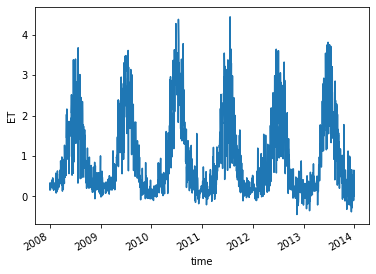

In [5]:
ec['ET'].resample(time='D').sum(skipna=False).plot()

### preproccess the data to run TEA

This next section will preprocess the original dataset to make a new dataset that is used by TEA. This process will calculate some derived variables and renames the variables to the TEA standards.

Also, note the **qualityFlag** variable, with designates periods with good quality data. Here we use the original data (QC=0) for LE and NEE.

Here we are using the nighttime partitioning from GPP (**GPP_NT**), if you would like to use the daytime partitioning, simply change this to **GPP_DT**.

In [6]:
timestamp = ec.time.values
ET        = ec.ET.values
GPP       = ec.GPP_DT.values
RH        = ec.RH.values
Rg        = ec.SW_IN.values
Rg_pot    = ec.SW_IN_POT.values
Tair      = ec.TA.values
VPD       = ec.VPD.values
precip    = ec.P.values
u         = ec.WS.values

qualityFlag = (ec.NEE_QC==0) & (ec.LE_QC==0)
qualityFlag = qualityFlag & np.isfinite(ec["ET"]) & np.isfinite(ec["GPP_NT"])

OtherVars = {'qualityFlag': qualityFlag}

ds = TEA.build_dataset(ec.time.values, ET, GPP, RH, Rg, Rg_pot, Tair, VPD, precip, u, OtherVars=OtherVars)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore', r'invalid value encountered in (less|less-equal|greater|true_divide)')
    ds = TEA.preprocess(ds,nStepsPerDay=nStepsPerDay)

Now **ds** is all ready to run TEA, with some new variables such as the conservative surface wetness index (CSWI). This is used by TEA to designate when surfaces are more likely to be dry, and typically any value less than -0.5 mm is used by TEA. Here we can make a plot of the CSWI and compare it to the -0.5 mm threshold.

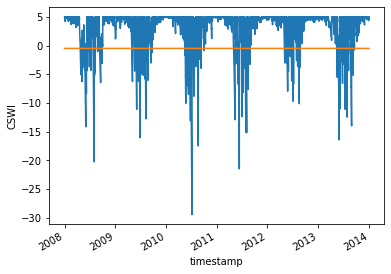

In [7]:
ds.CSWI.plot()
(ds.CSWI*0-0.5).plot(label='CSWI limit')

### running the partitioning

we are finally ready to run the actual partitioning. This step usually takes a couple minutes on a single processors (**n_jobs=1**). If you are running this on a machine with multiple processors, feel free to set this value to something higher, such as ***n_jobs=4*.

Also note the other parameters given to **TEA.partition**:

- **CSWIlims** - This is the CSWI limit to use. -0.5 is typically fine, but this can be increased using this parameter.
- **percs** - The prediction percentiles to output. If you are only interested in the outputs seen in the associated paper, you can set this to **[75]**, meaning it will only output the 75th percentile. It is currently set to output all percentiles from the 50th to the 100th by steps of 5. Note that increasing the number of percentiles output does not significantly increase processing times, but can result in large datasets.

In [8]:
%%time

n_jobs   = 4
CSWIlims = [-0.5]
percs    = [ 50,  55,  60,  65, 70, 75,  80,  85,  90,  95, 100]

ds = TEA.partition(ds,
       percs    = np.array(percs),
       CSWIlims = np.array(CSWIlims),
       RandomForestRegressor_kwargs = {'n_jobs':n_jobs}
       )

ds = ds.sel(CSWIlims=CSWIlims[0]) # Here we remove the dimension for CSWIlims, as there is only one, we don't need the extra dimensions.


CPU times: user 4 s, sys: 1.01 s, total: 5.02 s
Wall time: 34.5 s


### check the partitioning

Now, if your partitioning took only a couple seconds, it is likely that it failed, resulting in all NaN values for TEA_T. The next section of code will check if **ds.TEA_T** is all NaN, and if it is, it will look for missing variables. If any of the co-variates are missing, the partitioning cannot run. Some common missing variables are wind speed and precipitation.

In [9]:
if np.all(np.isnan(ds.TEA_T)):
    checkvars = ['Rg','Tair','RH','u','Rg_pot_daily','Rgpotgrad','year','GPPgrad','DWCI','C_Rg_ET','CSWI','precip'] # ,'precip'
    missingVars = []
    for var in checkvars:
        if np.all(~np.isfinite(ds[var].values)):
            missingVars.append(var)
    if len(missingVars)>0:
        print('TEA_NT failed to run on {site}, {missingVars} are missing in EC file'.format(site=site,missingVars=missingVars))
        #raise RuntimeError('TEA failed to run on {site}, {missingVars} are missing in EC file'.format(site=site,missingVars=missingVars))
    else:
        print('TEA_NT failed to run on {site}, unknown error'.format(site=site))
        #raise RuntimeError('TEA failed to run on {site}, unknown error'.format(site=site))
else:
    print("Partitioning seems OK.")

Partitioning seems OK.


Now we can check how the partitioning looks. The next section will aggrigate both ET and TEA_T to monthly values and plot them. Note that we select the 75th percentile, if you are curious about other percentiles, feel free to change **percentiles=75** to any of the values that we used above in **percs** (e.g. 95).

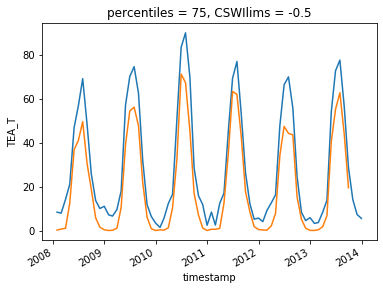

In [10]:
ds.ET.resample(timestamp='M').sum(skipna=False).plot()
ds.TEA_T.sel(percentiles=75).resample(timestamp='M').sum(skipna=False).plot()

Here we can look at the mean seasonal cycle of ET, TEA_T, and TEA_E.

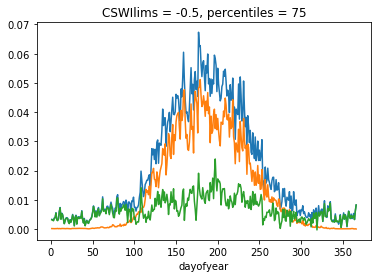

In [11]:
ds.ET.groupby('timestamp.dayofyear').mean().plot()
ds.TEA_T.sel(percentiles=75).groupby('timestamp.dayofyear').mean().plot()
(ds.ET-ds.TEA_T.sel(percentiles=75)).groupby('timestamp.dayofyear').mean().plot()

### data output

If you want to save your partitioned data, we can export directly to a netcdf format, which will preserve the current shape of the data.

In [12]:
ds.to_netcdf('FI-Hyy_TEA_output.nc')

or, the T estimate can be added to the original dataset and saved as netcdf

In [13]:
ec['TEA_T_NT_75'] = (('time'), ds.TEA_T.sel(percentiles=75).values)
ec['TEA_T_NT_75'] = ec['TEA_T_NT_75'].assign_attrs(long_name = 'transpiration from TEA using the 75th percentile, using GPP_NT',
                           units     = 'mm per timestep')

ds.to_netcdf('FI-Hyy_with_TEA.nc')

or back to a .csv file:

In [14]:
ec.to_dataframe().to_csv('FI-Hyy_with_TEA.csv')